In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
# Cause plots to be displayed in the notebook:
%matplotlib inline

In [3]:
from energy_functions import twoD_Gaussian,coupled_oscillator_energy_force

In [4]:
from optimize_functions import local_minimization,perturb_coordinates,acceptance_probability,basin_hopping

store info about local minima in arrays

In [5]:

# create local minima

np.random.seed(42)

nlocalminima=100
amps=np.zeros((nlocalminima))
offsets=np.zeros((nlocalminima))
xy0=np.zeros((nlocalminima,2))
sigma_xy=np.zeros((nlocalminima,2))
thetas=np.zeros((nlocalminima))


for i in range(nlocalminima):
    amps[i]=-10*np.abs(np.random.randn())
    offsets[i]=0 #-1*np.abs(np.random.randn())
    xy0[i,:]=4*np.random.rand(2)-2
    sigma_xy[i,:]=0.1*np.random.rand(2)
    thetas[i]=np.pi*np.random.randn()

<a list of 86 text.Text objects>

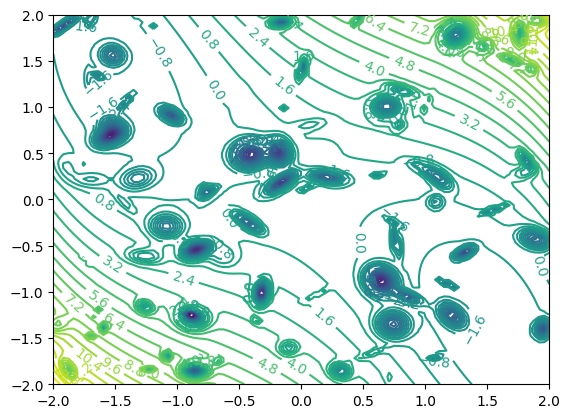

In [6]:
xmin,xmax=-2,2
x_points = np.linspace(-2,2,100)
y_points = np.linspace(-2,2,100)
X, Y = np.meshgrid(x_points, y_points)  
energies, xforces, yforces = coupled_oscillator_energy_force(X,Y,d0=0.3,a=1.0,k=2.2,lamb=1.978)
# this generate a surface for plotting local minima 
nx=np.zeros((100,100)) 
for i in range(nlocalminima):
    xo,yo=xy0[i,:]
    sigma_x,sigma_y=sigma_xy[i,:]
    nx=nx+twoD_Gaussian(X, Y, amps[i], xo, yo, sigma_x, sigma_y, thetas[i], offsets[i])
Z= nx + energies # nx
CS = plt.contour(X, Y, Z, levels=50)
plt.clabel(CS, inline=1, fontsize=10)

In [7]:
# redefine energy function so it takes in x,y as a vector 
def pes(x1,nlocalminima=nlocalminima,amps=amps,offsets=offsets,xy0=xy0,sigma_xy=sigma_xy,thetas=thetas,**kwargs):
    x,y=x1
    ene1,_,_=coupled_oscillator_energy_force(x,y,d0=0.3,a=1.0,k=2.2,lamb=1.978)
    nx=0
    for i in range(nlocalminima):
        xo,yo=xy0[i,:]
        sigma_x,sigma_y=sigma_xy[i,:]
        nx=nx+twoD_Gaussian(x, y, amps[i], xo, yo, sigma_x, sigma_y, thetas[i], offsets[i])
    return ene1+nx

(2, 100, 100)
<class 'numpy.ndarray'>


<a list of 115 text.Text objects>

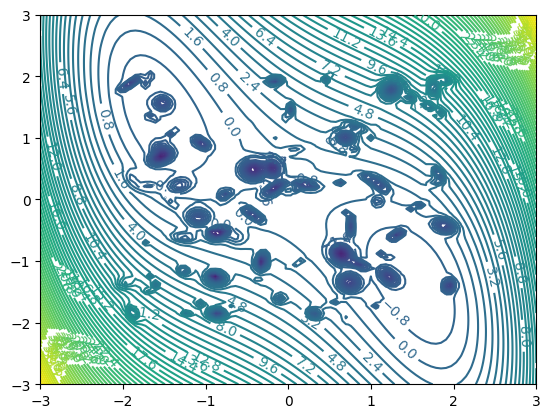

In [8]:
xmin,xmax=-3,3
x_points = np.linspace(xmin,xmax,100)
y_points = np.linspace(xmin,xmax,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=100)
plt.clabel(CS, inline=1, fontsize=10)

In [14]:
np.random.seed(42)
# X0=4*np.random.rand(2)-2
# X0=np.array([0.2,-1.2])
X0=np.array([1.5,1.0])
print(X0)
print(pes(X0))
fin,traj=basin_hopping(X0,pes, niter=100, stepsize=0.5, temperature=100.0)
# print(traj)

[1.5 1. ]
4.53575


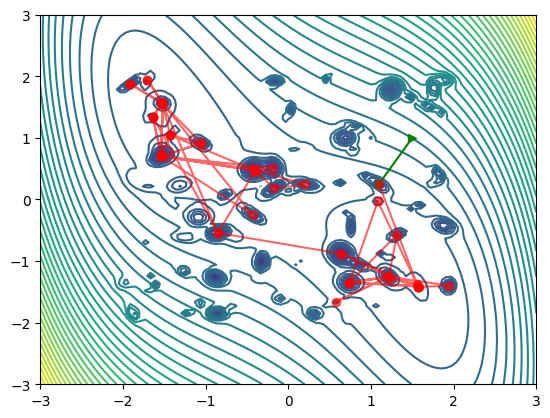

In [15]:

CS = plt.contour(X, Y, Z, levels=50)
CS = plt.plot([X0[0],traj[0,0]],[X0[1],traj[0,1]],'g>',linestyle='-')
CS = plt.plot(traj[:,0],traj[:,1],'ro',linestyle='-',markersize=6,alpha=0.6)

vs. sampling using sobol method

<AxesSubplot:>

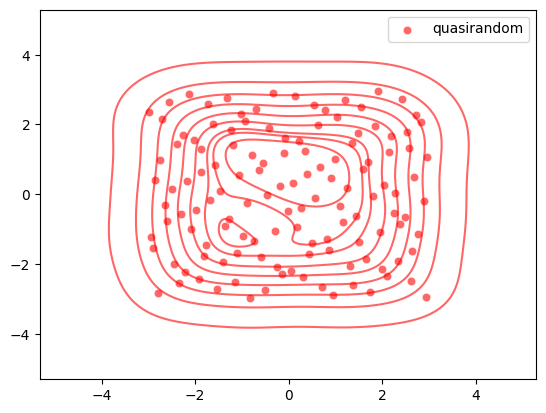

In [80]:
'''
see  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.Sobol.html
'''
from scipy.stats import qmc
# here use the more sophisticated scramble method 
sampler = qmc.Sobol(d=2,seed=42, scramble=True)  
# The balance properties of Sobol' points require n to be a power of 2.
qr_sample = sampler.random_base2(m=7) # this is 128 points 
# sample = sampler.random(128) # this is a similar way to get the points 
qr_sample=qr_sample*6.0-3 # rescale
# print(pr_sample)
sns.scatterplot(x=qr_sample[:,0],y=qr_sample[:,1],alpha=0.6,c='r',label='quasirandom')
sns.kdeplot(x=qr_sample[:,0],y=qr_sample[:,1],color='red',alpha=0.6,fill=False)
# _ = sampler.reset()
# _ = sampler.fast_forward(4)
# sample_continued = sampler.random_base2(m=2)
# print(sample_continued)

# or 

# _ = sampler.reset()

# sample = sampler.random(100)

# plt.plot(sample[:,0],sample[:,1],'.')
# plt.show()


In [96]:
qr_sample_opt=[]
for s in  qr_sample: 
    qr_sample_opt.append(local_minimization(s,pes))
qr_sample_opt=np.vstack(qr_sample_opt)

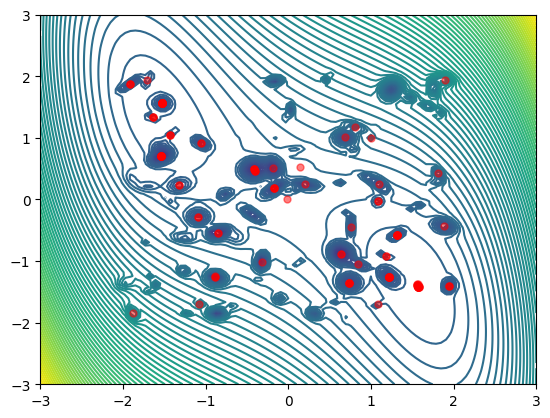

In [107]:
CS = plt.contour(X, Y, Z, levels=100)
qr_sample_opt[:10,:]
CS = plt.plot(qr_sample_opt[:,0],qr_sample_opt[:,1],'ro',markersize=5,alpha=0.5,linestyle='none')

<AxesSubplot:>

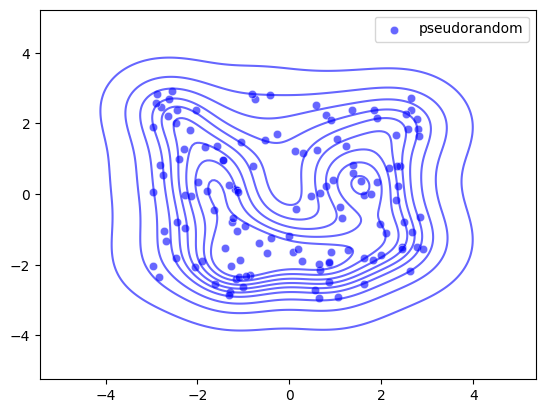

In [109]:
# pseudo-random
np.random.seed(42)
pr_sample=6*np.random.rand(128,2)-3
sns.scatterplot(x=pr_sample[:,0],y=pr_sample[:,1],alpha=0.6,c='b',label='pseudorandom')
sns.kdeplot(x=pr_sample[:,0],y=pr_sample[:,1],color='blue',alpha=0.6,fill=False)

In [111]:
pr_sample_opt=[]
for s in  pr_sample: 
    pr_sample_opt.append(local_minimization(s,pes))
pr_sample_opt=np.vstack(pr_sample_opt)

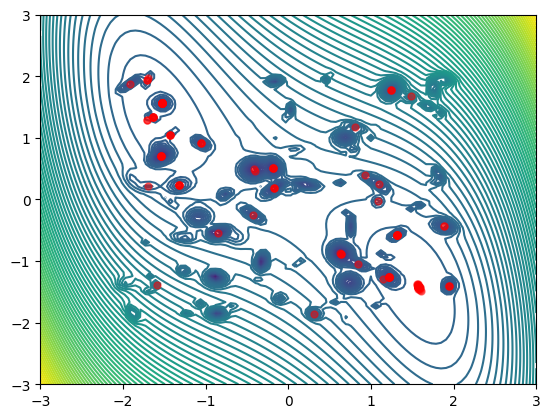

In [112]:
CS = plt.contour(X, Y, Z, levels=100)
pr_sample_opt[:10,:]
CS = plt.plot(pr_sample_opt[:,0],pr_sample_opt[:,1],'ro',markersize=5,alpha=0.5,linestyle='none')